### Build ACH Baselines
---

With label being simply `is_returned`
- FICO
- Deposit model v1
- LGBM model using v1 features

In [1]:
import json
import pandas as pd
import numpy as np
import pickle as pkl
from rdsutils.aws import download_s3 #, python_object_to_s3
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
import rdsutils.plot as rdsplot

%load_ext autoreload
%autoreload 2

#### Load data and define labels

In [2]:
modeling_df = pd.read_parquet('../../artifacts/20200920/modeling_df.parquet')
test_df = pd.read_parquet('../../artifacts/20200920/test_df.parquet')
modeling_df.shape, test_df.shape

((112599, 171), (88890, 171))

In [3]:
modeling_df.is_returned.value_counts()

False    108825
True       3774
Name: is_returned, dtype: int64

In [4]:
test_df.is_returned.value_counts()

False    84689
True      4201
Name: is_returned, dtype: int64

In [5]:
modeling_df['account_ending_balance'] = modeling_df['real_ending_balance']
modeling_df['days_since_first_transaction'] = modeling_df['days_since_first_deposit']
modeling_df['ach_target'] = modeling_df['is_returned']

#### Set features

In [6]:
# v1 features
v1_features = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'account_ending_balance', 'days_since_first_transaction'
              ]

v1_features_updated = ['transaction_amount', 'fico_score', 'vantage_score',
            'fraud_score_1', 'fraud_score_2', 'email_risk_score', 'phone_risk_score',  'all8220', 
            'iqt9415', 'all7120', 'mtf5820', 'bcc7120', 'bcc2800', 'iln5520', 'bcx3423', 'stu5031',
            'nr_direct_deposits', 'nr_past_returns', 'rolling_trns_as_pct_of_bal', 
            'nr_transactions_per_day', 'transaction_as_pct_of_balance', 
            'transaction_as_pct_of_bal_min', 'rolling_mean_acc_bal', 
              'real_ending_balance', # old 'account_ending_balance'
              'days_since_first_deposit' # old 'days_since_first_transaction'
              ]

In [7]:
# boruta features
fsel = pkl.load(open('../../artifacts/20200920/feature_selector_dict.pkl', 'rb'))
display(fsel.keys())
boruta_fimp = fsel['record_boruta_importance']
boruta_features = boruta_fimp[boruta_fimp.score>-10].feature.to_list()

dict_keys(['features', 'label_cols', 'base_features', 'record_missing', 'record_single_unique', 'record_collinear', 'record_boruta_importance', 'record_iv', 'ops', 'woe', 'acceptable_corr_range', 'record_collinear_pairs', 'missing_threshold'])

#### Download deposit model

In [8]:
model_v1 = pkl.load(open('../../models/deposit-v1/money-deposit-risk-1567033961.pkl', 'rb'))

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/sklearn/base.py:334: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.20.3 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [11]:
model_v1.importance_type

'split'

(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

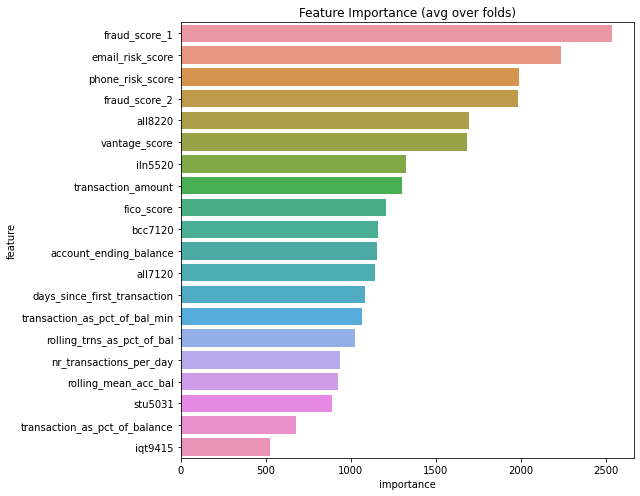

In [13]:
rdsplot.display_feature_importance(model_v1.feature_name_, 
                                   model_v1.feature_importances_, 
                                   max_n_features=20)

### Baselines
---

#### Get pred probability with Deposit V1 model

In [9]:
# make sure v1 features exist in modeling_df

modeling_df[model_v1.feature_name_].head()

,transaction_amount,account_ending_balance,fico_score,vantage_score,fraud_score_1,fraud_score_2,email_risk_score,phone_risk_score,all8220,iqt9415,...,bcx3423,stu5031,nr_direct_deposits,nr_past_returns,days_since_first_transaction,nr_transactions_per_day,transaction_as_pct_of_balance,rolling_trns_as_pct_of_bal,transaction_as_pct_of_bal_min,rolling_mean_acc_bal
5859,88.0,35259.43,NaN,NaN,0.0163,0.428,0.197,0.005,NaN,NaN,...,NaN,NaN,51,0,847,0.773318,0.002502,0.010872,-0.085234,37835.792174
6296,120.0,6439.15,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,785,0.442038,0.018990,0.018990,0.018990,6359.090000
6301,120.0,6472.36,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,799,0.440551,0.018891,0.018891,0.018891,6938.360000
6302,120.0,6592.44,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,812,0.434729,0.018540,0.018540,0.018540,6532.400000
6304,120.0,6712.44,NaN,NaN,0.1072,0.493,0.001,0.102,NaN,NaN,...,NaN,NaN,0,1,827,0.429262,0.018203,0.018203,0.018203,6652.440000


In [10]:
for feature in model_v1.feature_name_:
    modeling_df[feature] = modeling_df[feature].astype(float)
    
pred = model_v1.predict_proba(modeling_df[model_v1.feature_name_],
                              num_iteration=model_v1.best_iteration_)[:,1]
modeling_df['deposit_v1_pred'] = pred

<AxesSubplot:>

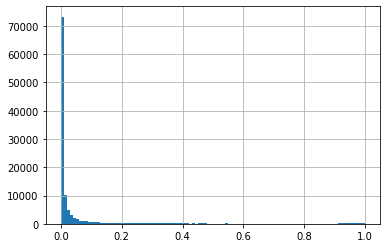

In [11]:
modeling_df['deposit_v1_pred'].hist(bins=100)

#### Train model with deposit v1 model features

In [12]:
seed = 12345
target_col = 'ach_target'
count_pos = modeling_df[target_col].sum()
count_neg = (~modeling_df[target_col]).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params = json.load(open('../../models/deposit-v1/params.json', 'rb'))
params['scale_pos_weight'] = pos_wgt_scaling_factor
params['verbosity'] = -1

In [13]:
pred, fimp_bl, model_bl, auc = train_lgb_baseline_grouped(modeling_df, v1_features_updated, 
                                                          params, target_col, seed=seed)
modeling_df['deposit_v1_updated_pred'] = pred

Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.94362	test's auc: 0.897059
[1000]	train's auc: 0.958649	test's auc: 0.893248
Early stopping, best iteration is:
[237]	train's auc: 0.929931	test's auc: 0.89871
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.940497	test's auc: 0.911984
[1000]	train's auc: 0.956403	test's auc: 0.9105
Early stopping, best iteration is:
[341]	train's auc: 0.932862	test's auc: 0.912292
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.943167	test's auc: 0.903226
[1000]	train's auc: 0.958245	test's auc: 0.899681
Early stopping, best iteration is:
[177]	train's auc: 0.923654	test's auc: 0.905268
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.943044	test's auc: 0.902261
[1000]	train's auc: 0.958341	test's auc: 0.899246
Early stopping, best iteration is:
[292]	train's auc: 0.932453	test's auc: 0.904968
Training until valid

,feature,importance,fold
0,transaction_amount,27686.647842,1
1,fico_score,34894.742687,1
2,vantage_score,581405.416416,1
3,fraud_score_1,12122.631611,1
4,fraud_score_2,4443.669285,1


(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

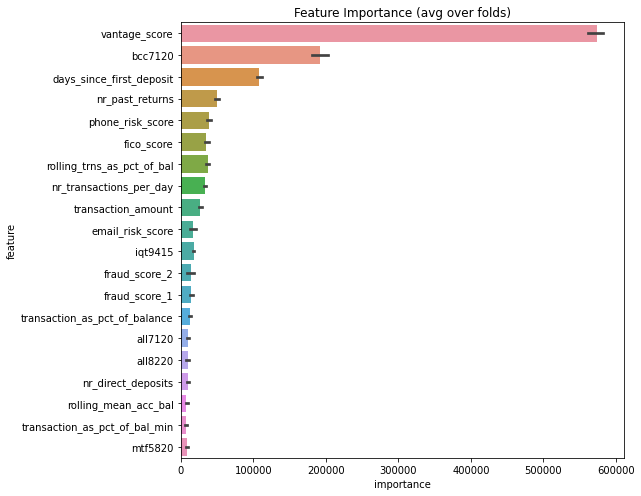

In [14]:
display(fimp_bl.head())
rdsplot.display_feature_importance(fimp_bl.feature, 
                                   fimp_bl.importance)

<AxesSubplot:>

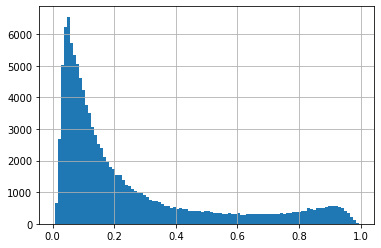

In [15]:
modeling_df['deposit_v1_updated_pred'].hist(bins=100)

#### Desposit v2 model Boruta selected features

In [16]:
seed = 12345

target_col = 'ach_target'
count_pos = modeling_df[target_col].sum()
count_neg = (~modeling_df[target_col]).sum()
pos_wgt_scaling_factor = count_neg / count_pos

params = {
    "objective" : "binary",
    "metric" : "auc",
    "boosting": 'gbdt',
    "max_depth" : 3,
    "num_leaves" : 10,
    "learning_rate" : 0.02,
    "feature_fraction" : 0.6,
    "lambda_l1": 10,
    "lambda_l2": 10, 
    "min_data_in_leaf": 50,
    "scale_pos_weight": pos_wgt_scaling_factor,
    "tree_learner": "serial",
    "boost_from_average": "false",
    "bagging_seed" : seed,
    "verbosity" : -1,
    "seed": seed
}

params_autogluon = {'feature_fraction': 0.361955253584467,
                    'lambda_l1': 17.620997660991137,
                    'lambda_l2': 6.817153595130293, 
                    'learning_rate': 0.09432285091125954, 
                    'max_depth': 3, 
                    'min_data_in_leaf': 41, 
                    'num_boost_round': 1759, 
                    'num_leaves': 11}

for p in params_autogluon:
    params[p] = params_autogluon[p]

In [17]:
pred_boruta, fimp_boruta, model_boruta, auc_boruta = train_lgb_baseline_grouped(modeling_df, boruta_features, 
                                                                                params, target_col, seed=seed)
modeling_df['boruta_pred'] = pred_boruta

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.972322	test's auc: 0.920012
[1000]	train's auc: 0.986535	test's auc: 0.918537
Early stopping, best iteration is:
[319]	train's auc: 0.962136	test's auc: 0.920527
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.972146	test's auc: 0.929564
[1000]	train's auc: 0.985933	test's auc: 0.926841
[1500]	train's auc: 0.991852	test's auc: 0.923996
Early stopping, best iteration is:
[521]	train's auc: 0.973129	test's auc: 0.929616
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.973491	test's auc: 0.918242
[1000]	train's auc: 0.986888	test's auc: 0.915814
Early stopping, best iteration is:
[160]	train's auc: 0.947936	test's auc: 0.919331
Training until validation scores don't improve for 1000 rounds
[500]	train's auc: 0.972839	test's auc: 0.922928
[1000]	train's auc: 0.986495	test's auc: 0.917807
Early stopping, best iteration is:
[194]	train's a

In [18]:
boruta_fimp.head()

,feature,score,mean_importance
15,first_deposit_amount,50.0,5.933170
79,vantage_score,50.0,5.410654
13,email_risk_score,37.0,3.720315
7,credit_card_loan_amount,33.0,3.479086
58,phone_risk_score,31.0,3.501729


(<Figure size 648x504 with 1 Axes>,
 <AxesSubplot:title={'center':'Feature Importance (avg over folds)'}, xlabel='importance', ylabel='feature'>)

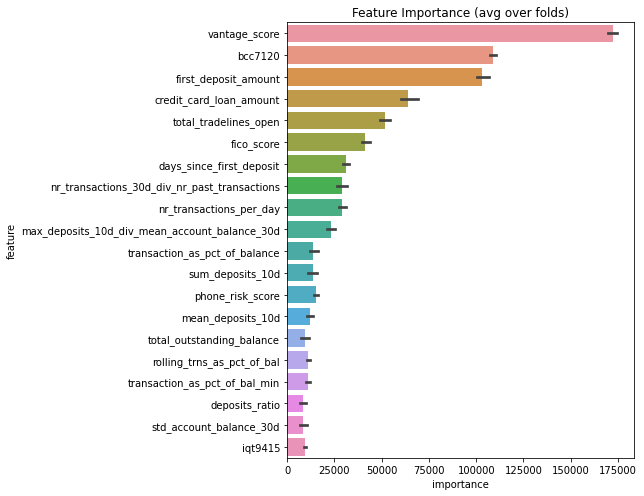

In [19]:
# # display all
# rdsplot.display_feature_importance(boruta_fimp.feature, 
#                                    boruta_fimp.mean_importance, 
#                                    max_n_features=60,
#                                    figsize=(16,16))

rdsplot.display_feature_importance(fimp_boruta.feature, 
                                   fimp_boruta.importance)

<AxesSubplot:>

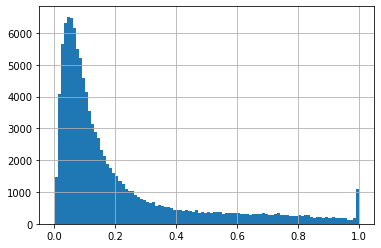

In [20]:
modeling_df['boruta_pred'].hist(bins=100)

### Comparing Results
---

In [21]:
import scikitplot as skplt
import matplotlib.pyplot as plt
from rdsutils.plot import plot_auc_curve_mult, plot_pr_curve_mult, plot_feature_over_time

plt.style.use('seaborn')

def get_binary_metrics(y_true, y_pred):
    from sklearn.metrics import roc_auc_score, average_precision_score
    from scikitplot.helpers import binary_ks_curve
    
    auc = round(roc_auc_score(y_true=y_true,
                              y_score=y_pred)*100, 2)
    ap = round(average_precision_score(y_true=y_true,
                                       y_score=y_pred)*100, 2)
    _, _, _, ks, _, _ = binary_ks_curve(y_true=y_true, y_probas=y_pred)
    ks = round(ks*100, 2) 
    
    metrics = {'auc': auc,
               'ap': ap,
               'ks': ks}

    return metrics


def get_pred_reports(df, target_col, pred_cols):
    import pandas as pd
    result = {}
    for col in pred_cols:
        metrics = get_binary_metrics(df[target_col], df[col])
        result[col] = metrics
    return pd.DataFrame(result).T

In [22]:
metrics = get_pred_reports(modeling_df, target_col, 
                           ['deposit_v1_pred', 'deposit_v1_updated_pred', 'boruta_pred'])
metrics

,auc,ap,ks
deposit_v1_pred,85.04,27.63,56.85
deposit_v1_updated_pred,90.53,34.58,67.63
boruta_pred,92.35,62.90,70.80


#### Plot Performances
---
To be honest the Blue Curve is a bit too good to be True... Double check there is no snooping bias

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

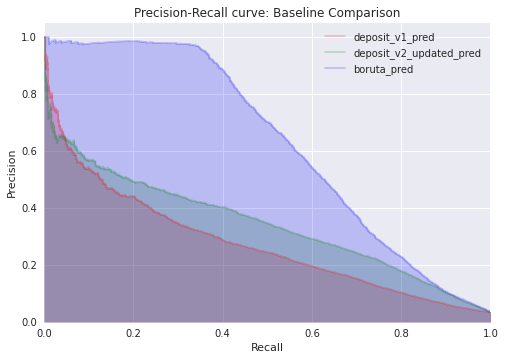

In [23]:
preds = [(modeling_df['deposit_v1_pred'], 'deposit_v1_pred'), 
         (modeling_df['deposit_v1_updated_pred'], 'deposit_v2_updated_pred'),
         (modeling_df['boruta_pred'], 'boruta_pred')]
title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

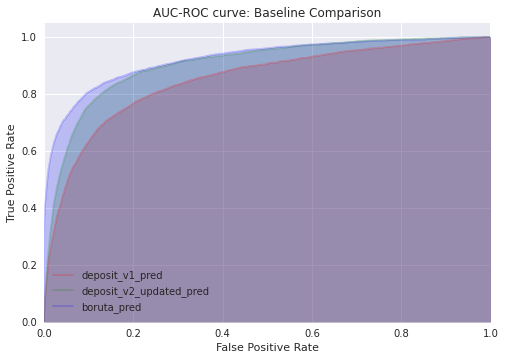

In [24]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(modeling_df[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

(<Figure size 1296x432 with 3 Axes>,
 array([<AxesSubplot:title={'center':'mean'}, xlabel='dt'>,
        <AxesSubplot:title={'center':'median'}, xlabel='dt'>,
        <AxesSubplot:title={'center':'count'}, xlabel='dt'>], dtype=object))

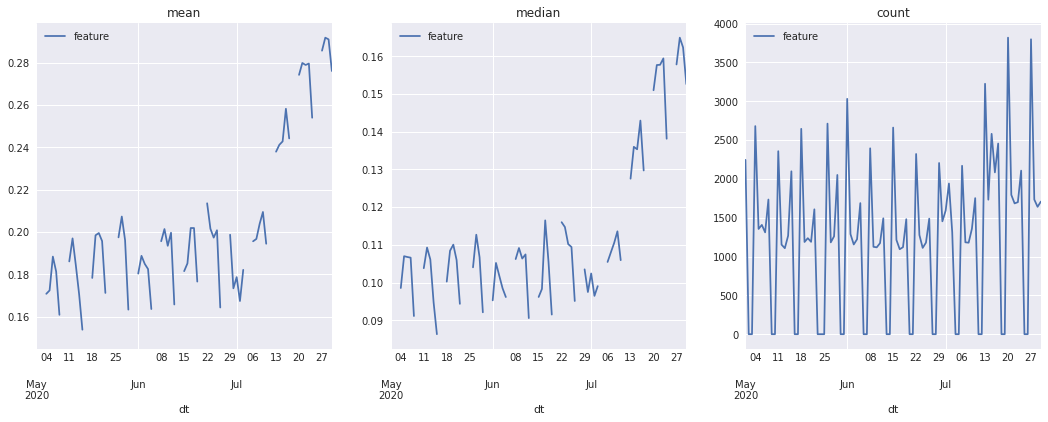

In [25]:
plot_feature_over_time(modeling_df.transaction_datetime, modeling_df.boruta_pred)

### Comparing Results with valid FICO for reporting
---

In [26]:
df_w_fico = modeling_df[~modeling_df.fico_score.isna()]
# logically good fico score -> lower fraud prob
# flip the direction to match with target 

df_w_fico['fico_pred'] = -df_w_fico['fico_score']  
metrics = get_pred_reports(df_w_fico, target_col, 
                           ['fico_pred', 'deposit_v1_pred', 
                            'boruta_pred'])
metrics

/home/ec2-user/anaconda3/envs/ml_basic_py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,auc,ap,ks
fico_pred,67.79,14.99,44.51
deposit_v1_pred,85.63,29.22,58.20
boruta_pred,92.56,64.05,71.37


(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'Precision-Recall curve: Baseline Comparison'}, xlabel='Recall', ylabel='Precision'>)

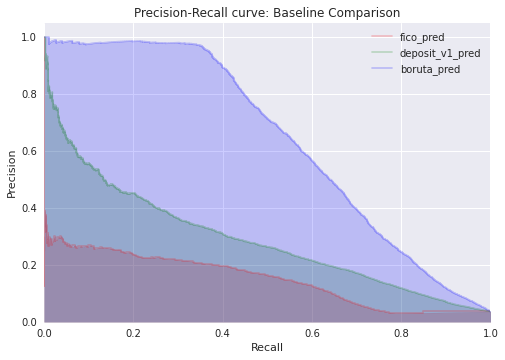

In [27]:
preds = [(df_w_fico['fico_pred'], 'fico_pred'),
         (df_w_fico['deposit_v1_pred'], 'deposit_v1_pred'), 
         (df_w_fico['boruta_pred'], 'boruta_pred')]
title = 'Precision-Recall curve: Baseline Comparison'
plot_pr_curve_mult(df_w_fico[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

(<Figure size 576x396 with 1 Axes>,
 <AxesSubplot:title={'center':'AUC-ROC curve: Baseline Comparison'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>)

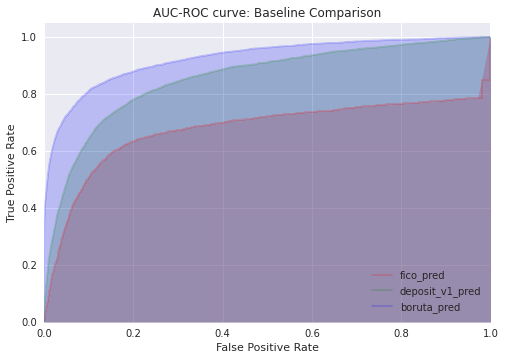

In [28]:
title = 'AUC-ROC curve: Baseline Comparison'
plot_auc_curve_mult(df_w_fico[target_col], preds,
                   title=title, colors = ['r', 'g', 'b'])

#### Save to artifacts

In [29]:
modeling_df.to_parquet('../../artifacts/20200920/modeling_df_w_baseline_preds.parquet')

In [30]:
models_baseline = {'deposit_v1': model_v1,
                   'deposit_v1_refitted': model_bl,
                   'boruta_baseline': model_boruta}
pkl.dump(models_baseline, open('../../artifacts/20200920/models_baseline.pkl', 'wb'))